# TITATNIC - MACHINE LEARNING FROM DISASTER

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

from re import search

from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted

import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from mlxtend.plotting import plot_learning_curves

In [2]:
# Global variables
SEED = 42
suptitle_param = dict(color='darkblue', fontsize=20)
title_param = {'color': 'darkred', 'fontsize': 16}

In [3]:
# Global configuration
np.random.seed(SEED)
plt.rcParams.update({'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 
                     'legend.fontsize': 10, 'font.size': 10})

In [4]:
# Global functions
def missingdata(data, ax=-1):
    """
    Plot the colums of a dataframes that have missing values.
    """
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms = ms[ms["Percent"] > 0]
    if ax == -1: f, ax =plt.subplots(figsize=(8,6))
    _ = sns.barplot(x=ms.index, y=ms["Percent"], color="green", alpha=0.8, ax=ax)
    ax.set_xlabel('Features')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Percent of missing values')
    ax.set_title('Percent missing data by feature', **title_param)
    if ax == -1: plt.show()
    return ms


def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# STEP 1 - READ DATA

In [5]:
# Read titanic data
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_test  = pd.read_csv('test.csv' , index_col='PassengerId')

### 1.1 Exploring Test Data:

In [6]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print('Pclass  :', df_test.Pclass.unique())
print('Sex     :', df_test.Sex.unique())
print('Embarked:', df_test.Embarked.unique())
print('Cabin   :', df_test.Cabin.unique())
df_test.info()

Pclass  : [3 2 1]
Sex     : ['male' 'female']
Embarked: ['Q' 'S' 'C']
Cabin   : [nan 'B45' 'E31' 'B57 B59 B63 B66' 'B36' 'A21' 'C78' 'D34' 'D19' 'A9'
 'D15' 'C31' 'C23 C25 C27' 'F G63' 'B61' 'C53' 'D43' 'C130' 'C132' 'C101'
 'C55 C57' 'B71' 'C46' 'C116' 'F' 'A29' 'G6' 'C6' 'C28' 'C51' 'E46' 'C54'
 'C97' 'D22' 'B10' 'F4' 'E45' 'E52' 'D30' 'B58 B60' 'E34' 'C62 C64' 'A11'
 'B11' 'C80' 'F33' 'C85' 'D37' 'C86' 'D21' 'C89' 'F E46' 'A34' 'D' 'B26'
 'C22 C26' 'B69' 'C32' 'B78' 'F E57' 'F2' 'A18' 'C106' 'B51 B53 B55'
 'D10 D12' 'E60' 'E50' 'E39 E41' 'B52 B54 B56' 'C39' 'B24' 'D28' 'B41'
 'C7' 'D40' 'D38' 'C105']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Par

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


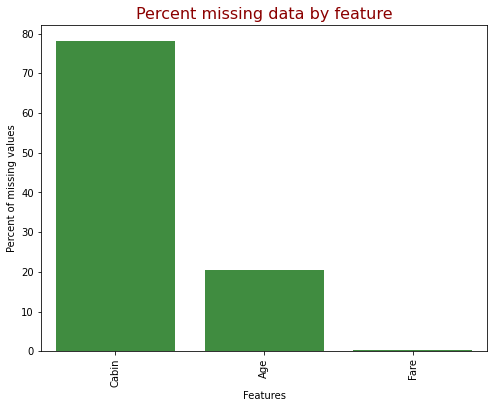

In [8]:
missingdata(df_test)

### 1.2 Exploring Train Data:

In [9]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
print('Pclass  :', df_train.Pclass.unique())
print('Sex     :', df_train.Sex.unique())
print('Embarked:', df_train.Embarked.unique())
print('Cabin   :', df_train.Cabin.unique())

Pclass  : [3 1 2]
Sex     : ['male' 'female']
Embarked: ['S' 'C' 'Q' nan]
Cabin   : [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


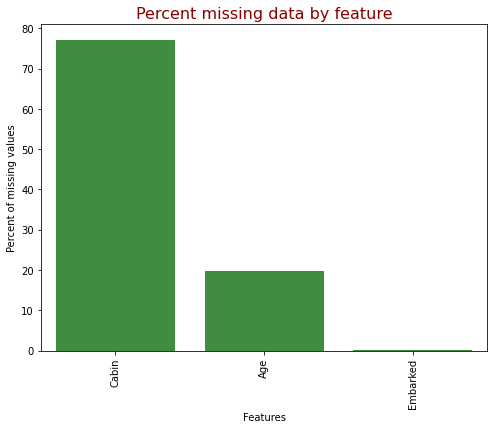

In [13]:
missingdata(df_train)

In [14]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df_train, 2, ["Age", "SibSp", "Parch", "Fare"])
df_train.loc[Outliers_to_drop]
#df_train = df_train.drop(Outliers_to_drop, axis = 0)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


# STEP 2 - EDA (EXPLORATION DATA ANALYSIS)

In [15]:
# Title type
title_sex = df_train[['Name','Sex','Survived']].append(df_test[['Name', 'Sex']])
title_sex['Title'] = title_sex.Name.str.extract('([A-Za-z]+)\.', expand = False)

print (title_sex['Title'].unique())

pd.pivot_table(title_sex, values='Survived', index='Sex', columns='Title', aggfunc='mean')
#title_sex.groupby(['Sex', 'Title']).Survived.mean()

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,NaN,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,NaN,0.697802,1.0,1.0,NaN,0.792,1.0,NaN,NaN
male,0.0,0.5,NaN,0.0,0.333333,0.0,NaN,0.5,0.575,NaN,NaN,NaN,0.156673,NaN,NaN,0.0,1.0


In [16]:
pd.pivot_table(title_sex, values='Name', index='Sex', columns='Title', aggfunc='count')

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,260.0,2.0,1.0,NaN,197.0,2.0,NaN,NaN
male,1.0,4.0,NaN,1.0,NaN,7.0,1.0,NaN,2.0,61.0,NaN,NaN,NaN,757.0,NaN,NaN,8.0,1.0


In [17]:
def group_title(df):
    df = df.copy(deep=True)
    
    # Get the title
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand = False)
    
    # Group title
    df['Title'] = df.Title.replace(['Master'                     ], 'Mr')
    df['Title'] = df.Title.replace(['Mme'                        ], 'Mrs')
    df['Title'] = df.Title.replace(['Ms', 'Mlle'                 ], 'Miss')
    df['Title'] = df.Title.replace(['Dona', 'Countess'           ], 'Lady')
    df['Title'] = df.Title.replace(['Don', 'Count'               ], 'Sir')
    df['Title'] = df.Title.replace(['Rev', 'Major', 'Col', 'Capt'], 'Sir')

    df.loc[df.query("Title in ['Dr','Jonkheer'] and Sex=='female'").index, 'Title'] = 'Lady'
    df.loc[df.query("Title in ['Dr','Jonkheer'] and Sex=='male'"  ).index, 'Title'] = 'Sir'
    return df.Title.values

df_ts = title_sex.copy(deep=True)
df_ts['Title'] = group_title(df_ts)
pd.pivot_table(df_ts, values='Survived', index='Sex', columns='Title', aggfunc='mean')

Title,Lady,Miss,Mr,Mrs,Sir
Sex,,,,,
female,1.0,0.702703,NaN,0.793651,NaN
male,NaN,NaN,0.186715,NaN,0.25


In [18]:
# Average Age
Average_Age = df_train.groupby(['Pclass', 'Sex']).Age.mean()
print(Average_Age)

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64


In [19]:
# Amount of Survived
survived = df_train.groupby(['Pclass', 'Survived']).Survived.count()
print(survived)
print(survived.groupby(level=[0]).apply(lambda g: g / g.sum()))

df_train.groupby('Survived').Survived.count()/df_train.shape[0]

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64
Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64


Survived
0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [20]:
# Looking for Fare less than $15
df_train[(df_train.Fare<15) & (df_train.Survived==1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
...,...,...,...,...,...,...,...,...,...,...,...
856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C


In [21]:
# Checking the free Fare
print('Minimun value (greater than $0.00  ): $', df_train[df_train.Fare>0].Fare.min())
print('Minimun value (greater than $4.0125): $', df_train[df_train.Fare>4.0125].Fare.min())
print(df_train.groupby('Fare').Fare.count())
df_train[(df_train.Fare<7) & (df_train.Age.isnull())]

Minimun value (greater than $0.00  ): $ 4.0125
Minimun value (greater than $4.0125): $ 5.0
Fare
0.0000      15
4.0125       1
5.0000       1
6.2375       1
6.4375       1
            ..
227.5250     4
247.5208     2
262.3750     2
263.0000     4
512.3292     3
Name: Fare, Length: 248, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S


In [22]:
# Looking for null values
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [23]:
# Exploring null Embarked data
df_train[df_train.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [24]:
# Exploring null Age data
df_train[df_train.Age.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [25]:
# Exploring the mean age per group
df_train.groupby(['Pclass', 'Sex', 'Embarked']).Age.mean()

Pclass  Sex     Embarked
1       female  C           36.052632
                Q           33.000000
                S           32.704545
        male    C           40.111111
                Q           44.000000
                S           41.897188
2       female  C           19.142857
                Q           30.000000
                S           29.719697
        male    C           25.937500
                Q           57.000000
                S           30.875889
3       female  C           14.062500
                Q           22.850000
                S           23.223684
        male    C           25.016800
                Q           28.142857
                S           26.574766
Name: Age, dtype: float64

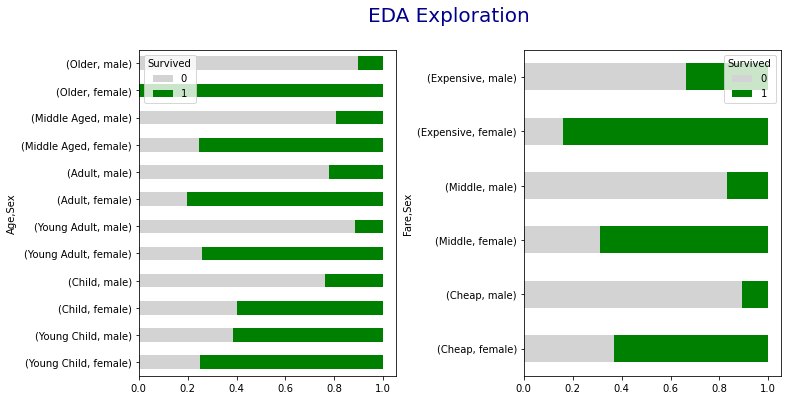

In [26]:
# Exploring from age and fare point of view
bins = [0, 7, 16, 25, 40, 60, 100]
binNames =['Young Child', 'Child', 'Young Adult', 'Adult', 'Middle Aged', 'Older']
binAge = pd.cut(df_train.Age, bins, labels=binNames)

binFare = pd.qcut(df_train.Fare, 3, labels=['Cheap', 'Middle', 'Expensive'])

fig, axes = plt.subplots(1,2, figsize=(11.5, 6))
binVars = [binAge, binFare]
for i in range(2):
    group = df_train.groupby([binVars[i], 'Sex', 'Survived'])
    group = group.size().unstack()
    group = group.div(group.sum(axis=1), axis=0)
    ax = group.plot(kind='barh', stacked=True, color=['lightgray', 'green'], ax=axes[i])

plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
fig.suptitle('EDA Exploration', **suptitle_param)
plt.show()

In [27]:
# Common value in Embarked column
df_train.Embarked.mode().values[0]

'S'

In [28]:
# Only nomerics columns
df_train.select_dtypes(include=np.number)

,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,0,3,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,1,3,26.0,0,0,7.9250
4,1,1,35.0,1,0,53.1000
5,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
887,0,2,27.0,0,0,13.0000
888,1,1,19.0,0,0,30.0000
889,0,3,NaN,1,2,23.4500


In [29]:
# Understanding Ticket feature
df = df_train.copy(deep=True)
df['TKT'] = np.array([int(tkt.split()[-1]) if tkt.split()[-1].isdigit() else 0 for tkt in df.Ticket.values])
dict_TKT = df.TKT.value_counts().reset_index(name="count")

print(dict_TKT.query("count > 5"))

dict_TKT = dict(dict_TKT.to_dict(orient='split')['data'])
#print(dict_TKT)

df['TKT_count'] = [dict_TKT[tkt] for tkt in df.TKT]
df[df.TKT==2144]

     index  count
0     1601      7
1     2343      7
2   347082      7
3   347088      6
4  3101295      6
5     2144      6


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TKT,TKT_count
PassengerId,,,,,,,,,,,,,
60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S,2144,6
72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S,2144,6
387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S,2144,6
481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S,2144,6
679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,2144,6
684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S,2144,6


### 2.1 The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

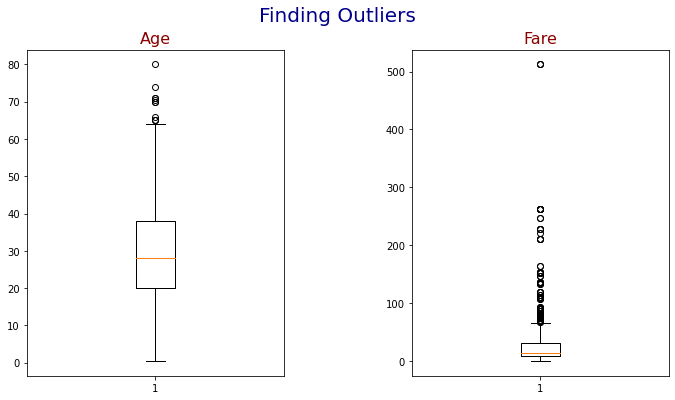

In [30]:
###################################################################################
## CORRECTING
## Reviewing the data, there does not appear to be any aberrant or non-acceptable 
## data inputs. In addition, we see we may have potential outliers.
###################################################################################
fig, axes = plt.subplots(1,2, figsize=(11.5, 6))
plot_columns = ['Age', 'Fare']
for i in range(2):
    axes[i].boxplot(df_train[df_train[plot_columns[i]].notnull()][plot_columns[i]])
    axes[i].set_title(plot_columns[i], **title_param)

plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
fig.suptitle('Finding Outliers', **suptitle_param)
plt.show()

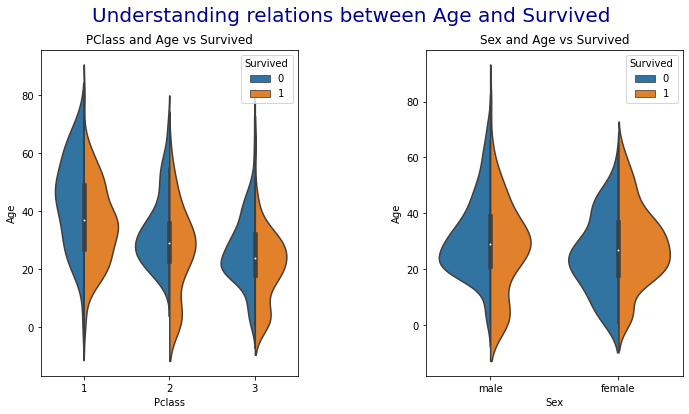

In [31]:
fig, axes = plt.subplots(1,2, figsize=(11.5, 6))

ax = axes[0]
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df_train, split=True, ax=ax)
ax.set_title('PClass and Age vs Survived')
ax = axes[1]
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df_train, split=True, ax=ax)
ax.set_title('Sex and Age vs Survived')

plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
fig.suptitle('Understanding relations between Age and Survived', **suptitle_param)
plt.show()

# STEP 3 - FEATURE ENGINEERING

### 3.1 Deal with Null values: Simple "Unknown" imputation

In [32]:
class UnknownImputation(BaseEstimator, TransformerMixin):
    '''
    Class for imputing missing values in a pd.DataFrame using an specific value ('Unknown' description is default).
    
    Parameters
    ----------    
    target_cols : list
        List of columns to impute 'Unknown' value 
    Returns
    -------
    X : Pandas DataFrame
        Dataframe with imputed values in the target column
    fill_value: value for imputation, 'Unknown' as default
    '''
    def __init__(self, target_cols, fill_value='Unknown'):
        assert type(target_cols) == list, 'target_cols should be a list of columns'
        
        self.target_cols = target_cols
        self.impute_map_ = fill_value
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy(deep = True)
        for col in self.target_cols:
            X[col].fillna(self.impute_map_, inplace=True)
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def predict(self, X):
        self.transform(X)
        return None

### 3.2 Deal with Null values: Base on mean and std

In [33]:
class MeanStdImputation(BaseEstimator, TransformerMixin):
    '''
    Class for imputing missing values based on mean and std.
    
    Parameters
    ----------    
    target_cols : list
        List of columns to impute 'Unknown' value 
    Returns
    -------
    X : Pandas DataFrame
        Dataframe with imputed values in the target column
    '''
    def __init__(self, target_cols):
        assert type(target_cols) == list, 'target_cols should be a list of columns'
        
        self.target_cols = target_cols
    
    def fit(self, X, y=None):
        self.dict_col_ = {}
        for col in self.target_cols:
            self.dict_col_ = {col: {'mean': X[col].mean(), 'std': X[col].std()}}
        return self 
    
    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'target_cols')
        check_is_fitted(self, 'dict_col_')
        
        X = X.copy(deep = True)
        for col in self.target_cols:
            # identify null values
            X_slice = X[col].isnull()
            
            # compute random numbers between the mean, std and X_slice
            rand_col = np.random.randint(self.dict_col_[col]['mean'] - self.dict_col_[col]['std'], 
                                         self.dict_col_[col]['mean'] + self.dict_col_[col]['std'], size = X_slice.sum())
            
            # fill NaN values in col column with random values generated
            X_col = X[col].copy()
            X_col[X_slice] = rand_col
            X[col] = X_col
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def predict(self, X):
        self.transform(X)
        return None

### 3.3 Deal with Null values - Group imputation class

In [34]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : Pandas DataFrame
        Dataframe with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        self.impute_map_ = X.groupby(self.group_cols)[self.target].mean().reset_index()
        self.impute_map_.columns = self.group_cols + [self.target + '_mean']
        return self 
    
    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy(deep = True)
        c_target = pd.merge(X, self.impute_map_, how='left', on=self.group_cols)[self.target + '_mean']
        X[self.target] = np.where(X[self.target].isnull(), c_target, X[self.target])
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def predict(self, X, y=None):
        self.transform(X)
        return y

### 3.4 Custom Feature Adition Class

In [151]:
class FeatureMaker(BaseEstimator, TransformerMixin):
    '''
    Class used for add specific custom feature to Titanic Dataset.
    
    Returns
    -------
    X : Pandas DataFrame
        Titanic dataset with new features (Title, Deck, FamilySize).
    '''
    def fit(self, X, y=None):
        # Cleaning the ticket number column
        X = X.copy(deep = True)
        X['Survived'] = y
        
        # Cleaning Ticket column
        X['TKT'] = np.array([int(tkt.split()[-1]) if tkt.split()[-1].isdigit() else 0 for tkt in X.Ticket.values])
        
        # select females and masters (boys)
        boy    = (X.Name.str.contains('Master')) | ((X.Sex == 'male') & (X.Age < 13))
        female = (X.Sex == 'female')
        self.__BoyOrFemale__ = boy | female

        # no. females + boys on ticket
        self.__TKTcount__ = X[self.__BoyOrFemale__].groupby('TKT').Survived.count()

        # survival rate amongst females + boys on ticket
        self.__tick_surv__ = X[self.__BoyOrFemale__].groupby('TKT').Survived.mean()
        
        # Prepare data for Fare categorical feature
        self.__fare_labels__ = ['VeryLow', 'Low', 'Medium', 'High']
        _, self.__fare_bins__ = pd.qcut(X.Fare, 4, labels=self.__fare_labels__, retbins=True)
        
        return self 
    
    
    def transform(self, X, y=None):
        # Make sure that the properties was fitted 
        check_is_fitted(self, '__BoyOrFemale__')
        check_is_fitted(self, '__TKTcount__')
        check_is_fitted(self, '__tick_surv__')
        check_is_fitted(self, '__fare_labels__')
        check_is_fitted(self, '__fare_bins__')
        
        # Def local functions
        def get_the_deck(text):
            if text == "Unknown": return "Unknown"
            return text[0]
        
        # Def local variables
        cabin_labels = ['Unknown', 'A', 'B', 'C', 'D', 'E', 'F', 'T', 'G']
        X = X.copy(deep = True)
        
        # Adding new features
        X['Deck']       = X['Cabin'].fillna('Unknown').apply(lambda cab: get_the_deck(cab))
        X['FamilySize'] = X['SibSp'] + X['Parch'] 
        
        # Working with title
        X['Title']      = X.Name.str.extract('([A-Za-z]+)\.', expand = False)
        X['Title']      = X.Title.replace(['Master'                     ], 'Mr')
        X['Title']      = X.Title.replace(['Mme'                        ], 'Mrs')
        X['Title']      = X.Title.replace(['Ms', 'Mlle'                 ], 'Miss')
        X['Title']      = X.Title.replace(['Dona', 'Countess'           ], 'Lady')
        X['Title']      = X.Title.replace(['Don', 'Count'               ], 'Sir')
        X['Title']      = X.Title.replace(['Rev', 'Major', 'Col', 'Capt'], 'Rare')
        X.loc[X.query("Title in ['Dr','Jonkheer'] and Sex=='female'").index, 'Title'] = 'Lady'
        X.loc[X.query("Title in ['Dr','Jonkheer'] and Sex=='male'"  ).index, 'Title'] = 'Sir'
        
        # Transforming to categorical some columns
        X['Pclass']     = pd.Categorical(X.Pclass, categories=[1, 2, 3], ordered=True)
        X['Sex']        = pd.Categorical(X.Sex, categories=['male', 'female'], ordered=True)
        X['Embarked']   = pd.Categorical(X.Embarked, categories=['C', 'Q', 'S'], ordered=True) #'Unknown', 
        X['Title']      = pd.Categorical(X.Title, categories=['Rare','Mr', 'Mrs', 'Miss', 'Lady', 'Sir'], ordered=True)
        X['Deck']       = pd.Categorical(X.Deck, categories=cabin_labels, ordered=True)
        
        # Working with Ticket columns
        X['TKT']        = np.array([int(tkt.split()[-1]) if tkt.split()[-1].isdigit() else 0 for tkt in X.Ticket.values])
        X['Boy']        = ((X.Name.str.contains('Master')) | ((X.Sex=='male') & (X.Age<13))).astype(int)
        
        # if ticket exists in training data, fill NTicket with no. women+boys on that ticket in the training data.
        X['TKTcount']   = X.TKT.replace(self.__TKTcount__)
        # otherwise NTicket=0
        X.loc[~X.TKT.isin(self.__TKTcount__.index), 'TKTcount'] = 0

        # if ticket exists in training data, fill TicketSurv with women+boys survival rate in training data  
        X['TicketSurv'] = X.TKT.replace(self.__tick_surv__)
        # otherwise TicketSurv=0
        X.loc[~X.TKT.isin(self.__tick_surv__.index),'TicketSurv'] = 0
        
        # Creating IsAlone feature
        #X['IsAlone']    = (X.FamilySize == 0)
        #X['IsAlone']    = X['IsAlone'].astype(int)
        #X.drop(['FamilySize', 'SibSp', 'Parch'], axis=1, inplace=True)
        
        # Deleting unnecessary features
        X['TicketSurv'] = X['TicketSurv'].astype(int)
        X['TKTcount']   = X['TKTcount'].astype(int)
        
        # Working with age and fare as categorical features
        #age_labels      = ['Young Child', 'Child', 'Young Adult', 'Adult', 'Middle Aged', 'Older']
        #X['Age']        = pd.cut(X['Age'], bins=[0, 7, 16, 25, 40, 60, 100], labels=age_labels)
        #X['Fare']       = pd.cut(X['Fare'], bins=self.__fare_bins__, labels=self.__fare_labels__)
        #X['Age']        = pd.Categorical(X.Age, categories=age_labels, ordered=True)
        #X['Fare']       = pd.Categorical(X.Fare, categories=self.__fare_labels__, ordered=True)
        
        # Deleting unnecesary features
        X.drop(['Name', 'Ticket', 'Cabin', 'TKT'], axis=1, inplace=True)
        #X.drop(['TKTcount', 'TicketSurv'], axis=1, inplace=True)
        
        return X
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    
    def predict(self, X, y=None):
        return y

### 3.5 Pandas standarized class

In [152]:
class PandasNormalized(BaseEstimator, TransformerMixin):
    '''
    Class used to Normalize a Dataset.
    
    Returns
    -------
    X : Pandas DataFrame
    '''
    def __init__(self, scalar=MinMaxScaler()):
        self.scalar = scalar
        #self.scalar = StandardScaler()
    
    
    def fit(self, X, y=None):
        self.scalar.fit(X.select_dtypes(include=np.number))
        return self
    
    
    def transform(self, X, y=None):
        df = X.select_dtypes(include=np.number)
        df = pd.DataFrame(data = self.scalar.transform(df), columns = df.columns, index=X.index)
        return pd.concat([X.select_dtypes(exclude=np.number), df], axis=1)
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    
    def predict(self, X, y=None):
        return y

### 3.6 Pandas encoder class

In [153]:
class PandasEncoder(BaseEstimator, TransformerMixin):
    '''
    Class used for encoder categorical variables.
    
    Returns
    -------
    X : Pandas DataFrame
        Titanic dataset with new features (Title, Deck, FamilySize).
    '''
    def fit(self, X, y=None):
        return self 
    
    
    def transform(self, X, y=None):
        X = pd.get_dummies(X, drop_first=True)
        
        return X
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    
    def predict(self, X, y=None):
        return y

# STEP 4 - PREPARING ENVIRONMENT TO APPLY ML

### 4.1 Read and transform data

In [154]:
##############################################
## GETTING DATA
##############################################
# Create arrays for the features and the target: X, y
X, y = df_train.drop('Survived', axis=1), df_train.Survived


##############################################
## TRANSFORMING DATA
##############################################
# Column transformation
Categorical_Transformation = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include='category')),
    remainder = MinMaxScaler(), sparse_threshold = 0    
)

# Setup the pipeline steps: steps
steps = [#('Unknown_Fare'     , UnknownImputation(target_cols=['Fare'], fill_value=0)),
         ('Unknown_Fare'     , UnknownImputation(target_cols=['Fare'], fill_value=df_train.Fare.dropna().median())),
         #('Unknown_Embarked' , UnknownImputation(target_cols=['Embarked'])),
         ('Unknown_Embarked' , UnknownImputation(target_cols=['Embarked'], fill_value=df_train.Embarked.mode().values[0])),
         ('Group_Imp'        , GroupImputer(group_cols=['Pclass', 'Sex'], target='Age', metric='mean')),
         #('MeanStdImputation', MeanStdImputation(['Age'])),
         ('Feature_Maker'    , FeatureMaker()),
         #('Scalar'           , PandasNormalized(scalar=StandardScaler())),
         ('Scalar'           , PandasNormalized()),
         ('Encoder'          , PandasEncoder())
        ]

# Create the pipeline: xgb_pipeline
data_pipeline = Pipeline(steps)


# Transform data
X = data_pipeline.fit_transform(X, y)

##############################################
## SPLIT DATA
##############################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
#X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED, stratify=y_test)

# define the datasets to evaluate the model
evalset = [(X_train, y_train), (X_test, y_test)]

# Reviewing the data
print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    float64
 2   Parch       891 non-null    float64
 3   Fare        891 non-null    float64
 4   FamilySize  891 non-null    float64
 5   Boy         891 non-null    float64
 6   TKTcount    891 non-null    float64
 7   TicketSurv  891 non-null    float64
 8   Pclass_2    891 non-null    uint8  
 9   Pclass_3    891 non-null    uint8  
 10  Sex_female  891 non-null    uint8  
 11  Embarked_Q  891 non-null    uint8  
 12  Embarked_S  891 non-null    uint8  
 13  Deck_A      891 non-null    uint8  
 14  Deck_B      891 non-null    uint8  
 15  Deck_C      891 non-null    uint8  
 16  Deck_D      891 non-null    uint8  
 17  Deck_E      891 non-null    uint8  
 18  Deck_F      891 non-null    uint8  
 19  Deck_T      891 non-null    u

,Age,SibSp,Parch,Fare,FamilySize,Boy,TKTcount,TicketSurv,Pclass_2,Pclass_3,...,Deck_D,Deck_E,Deck_F,Deck_T,Deck_G,Title_Mr,Title_Mrs,Title_Miss,Title_Lady,Title_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.271174,0.125,0.0,0.014151,0.1,0.0,0.000000,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.472229,0.125,0.0,0.139136,0.1,0.0,0.166667,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.321438,0.000,0.0,0.015469,0.0,0.0,0.166667,1.0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.434531,0.125,0.0,0.103644,0.1,0.0,0.166667,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0.434531,0.000,0.0,0.015713,0.0,0.0,0.000000,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [121]:
X.describe()

,Age,Fare,IsAlone,Boy,TKTcount,TicketSurv,Pclass_2,Pclass_3,Sex_female,Embarked_Q,...,Deck_D,Deck_E,Deck_F,Deck_T,Deck_G,Title_Mr,Title_Mrs,Title_Miss,Title_Lady,Title_Sir
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.363140,0.062858,0.602694,0.046016,0.150393,0.354658,0.206510,0.551066,0.352413,0.086420,...,0.037037,0.035915,0.014590,0.001122,0.004489,0.625140,0.141414,0.207632,0.003367,0.010101
std,0.166890,0.096995,0.489615,0.209637,0.208923,0.478678,0.405028,0.497665,0.477990,0.281141,...,0.188959,0.186182,0.119973,0.033501,0.066890,0.484359,0.348644,0.405840,0.057961,0.100051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.268032,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.327816,0.028213,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.447097,0.060508,1.000000,0.000000,0.166667,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [122]:
##############################################
## TRANSFORMING DF_TEST
##############################################
# Transform data
X_final_test = data_pipeline.transform(df_test)
X_final_test.head()

,Age,Fare,IsAlone,Boy,TKTcount,TicketSurv,Pclass_2,Pclass_3,Sex_female,Embarked_Q,...,Deck_D,Deck_E,Deck_F,Deck_T,Deck_G,Title_Mr,Title_Mrs,Title_Miss,Title_Lady,Title_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0.428248,0.015282,1.0,0.0,0.000000,0.0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
893,0.585323,0.013663,0.0,0.0,0.000000,0.0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
894,0.773813,0.018909,1.0,0.0,0.000000,0.0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
895,0.334004,0.016908,1.0,0.0,0.000000,0.0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
896,0.271174,0.023984,0.0,0.0,0.166667,1.0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


### 4.2 Preparing the result environment

In [123]:
ml_result = {}

# STEP 5 - LOOKING FOR THE BEST MODEL APPROACH

## 5.1 APPLYING XGBOOST MODEL

### 5.1.1 Model approach

Accuracy on the training set:  0.9094171212566516
Accuracy on the test set    :  0.8938547486033519


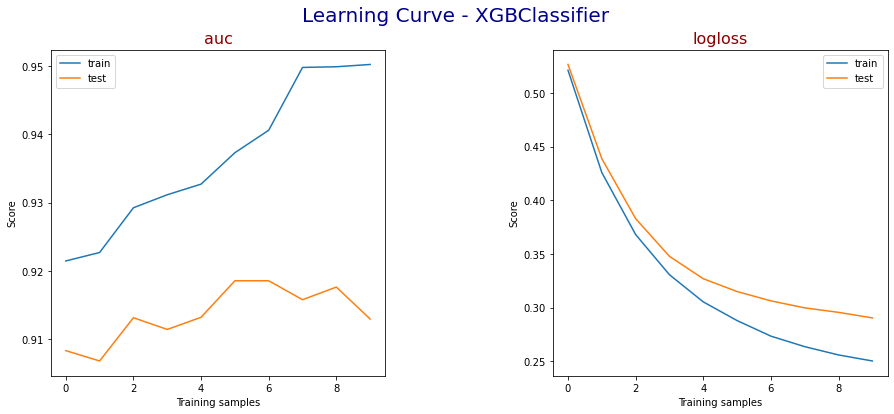

In [137]:
##############################################
## Applying model
##############################################
# Params for xgb.XGBClassifier
xgb_params = dict(objective='binary:logistic', n_estimators=10, use_label_encoder=False, eval_metric='error', 
                  max_depth=3, seed=SEED)

# Setup the pipeline steps: steps
ml_XGBClassifier = xgb.XGBClassifier(**xgb_params)

# Perform cross-validation
cvs_scores = cross_val_score(ml_XGBClassifier, X_train, y_train, cv=3, scoring='roc_auc')

# Print avg. AUC
print("Accuracy on the training set: ", np.mean(cvs_scores))

# Fit the classifier to the training set
metrics = ['auc', 'logloss']
ml_XGBClassifier.fit(X_train, y_train, eval_metric=metrics, eval_set=evalset, verbose=0)

# Predict the labels of the test set: preds
preds = ml_XGBClassifier.predict(X_test)

# evaluate performance - Compute the accuracy: accuracy
print("Accuracy on the test set    : ", np.mean(accuracy_score(y_test, preds)))

##############################################
## Plotting learning curve
##############################################
# retrieve performance metrics
results = ml_XGBClassifier.evals_result()

# plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, metric in zip(axes, metrics):
    ax.plot(results['validation_0'][metric], label='train')
    ax.plot(results['validation_1'][metric], label='test')
    ax.legend()
    ax.set_title(metric, **title_param)
    ax.set_xlabel('Training samples')
    ax.set_ylabel('Score')
fig.suptitle('Learning Curve - XGBClassifier', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
plt.show()

### 5.1.2 Relations inside

Number of trees: 10


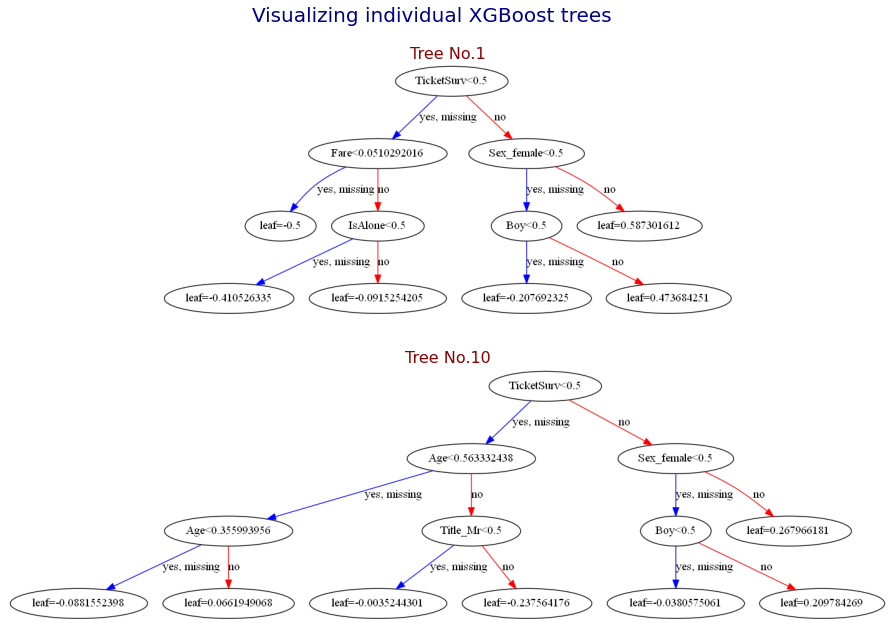

In [138]:
##############################################
## Relations inside
##############################################
print('Number of trees:', ml_XGBClassifier.get_num_boosting_rounds()) #also xg_cl.n_estimators

# Plot the some tree
n_tree = [0,9]
size = len(n_tree)
fig, axes = plt.subplots(size, 1, figsize=(17, 5*size))
for i in n_tree:
    ax = axes[n_tree.index(i)]
    xgb.plot_tree(ml_XGBClassifier, num_trees=i, ax=ax)
    ax.set_title('Tree No.{}'.format(i+1), **title_param)
fig.suptitle('Visualizing individual XGBoost trees', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=.9, hspace=.2, wspace=None)
plt.show()

### 5.1.3 Features Importances

[('TicketSurv', 0.61753863),
 ('Sex_female', 0.10246038),
 ('Title_Mr', 0.053136114),
 ('Boy', 0.04902863),
 ('IsAlone', 0.04245179),
 ('Deck_E', 0.03388345),
 ('Fare', 0.03219942),
 ('Deck_D', 0.027328616),
 ('TKTcount', 0.027099434),
 ('Age', 0.014873592),
 ('Title_Sir', 0.0),
 ('Title_Mrs', 0.0),
 ('Title_Miss', 0.0),
 ('Title_Lady', 0.0),
 ('Pclass_3', 0.0),
 ('Pclass_2', 0.0),
 ('Embarked_S', 0.0),
 ('Embarked_Q', 0.0),
 ('Deck_T', 0.0),
 ('Deck_G', 0.0),
 ('Deck_F', 0.0),
 ('Deck_C', 0.0),
 ('Deck_B', 0.0),
 ('Deck_A', 0.0)]


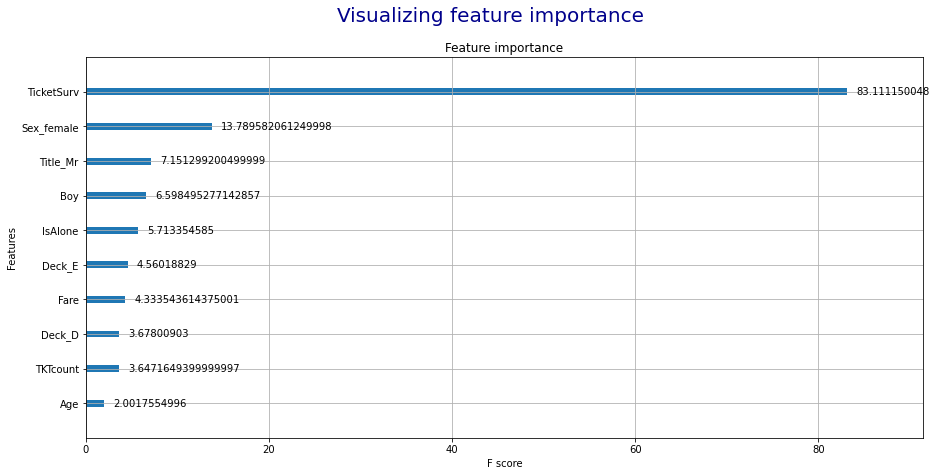

In [139]:
##############################################
## Features Importances
##############################################
feature_importance = {k:v for k,v in zip(ml_XGBClassifier.get_booster().feature_names, ml_XGBClassifier.feature_importances_)}
pprint(sorted(feature_importance.items(), key=lambda x: (x[1],x[0]), reverse=True))

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15, 7))
xgb.plot_importance(ml_XGBClassifier, ax=ax, importance_type='gain')
fig.suptitle('Visualizing feature importance', **suptitle_param)
plt.show()

In [141]:
selected_features = [key for key in feature_importance.keys() if feature_importance[key]>0] #unordered
selected_features = [k for k,v in sorted(feature_importance.items(), key=lambda x: (x[1],x[0]), reverse=True) if v>0] #ordered
selected_features

['TicketSurv',
 'Sex_female',
 'Title_Mr',
 'Boy',
 'IsAlone',
 'Deck_E',
 'Fare',
 'Deck_D',
 'TKTcount',
 'Age']

In [46]:
# define the datasets to evaluate the model with selected_features
#X_train = X_train[selected_features]
#X_test  = X_test[selected_features]
#evalset = [(X_train, y_train), (X_test, y_test)]

### 5.1.4 Tunning the model

In [150]:
##############################################
## Tunning the model
##############################################
ml_XGBClassifier = xgb.XGBClassifier()
param_grid     = {'objective'         : ['binary:logistic'],
                  'n_estimators'      : [100, 200, 500, 1000],
                  'use_label_encoder' : [False], 
                  'eval_metric'       : ['error'],
                  'learning_rate'     : np.linspace(0.01, 0.1, 20), 
                  'max_depth'         : range(3,12),
                 }
scoring        = 'roc_auc'

grid_mse = GridSearchCV(estimator=ml_XGBClassifier, param_grid=param_grid, scoring=scoring, cv=4, verbose=0)
grid_mse.fit(X_train, y_train)

best_params_XGBClassifier = grid_mse.best_params_

print("Best parameters found: "); pprint(best_params_XGBClassifier)
print("Best {} found: ".format(scoring), grid_mse.best_score_)

Best parameters found: 
{'eval_metric': 'error',
 'learning_rate': 0.0668421052631579,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'use_label_encoder': False}
Best roc_auc found:  0.9273520461780099


### 5.1.5 Set best params in the model

Accuracy on the training set:  0.9030898876404494
Accuracy on the test set    :  0.8938547486033519


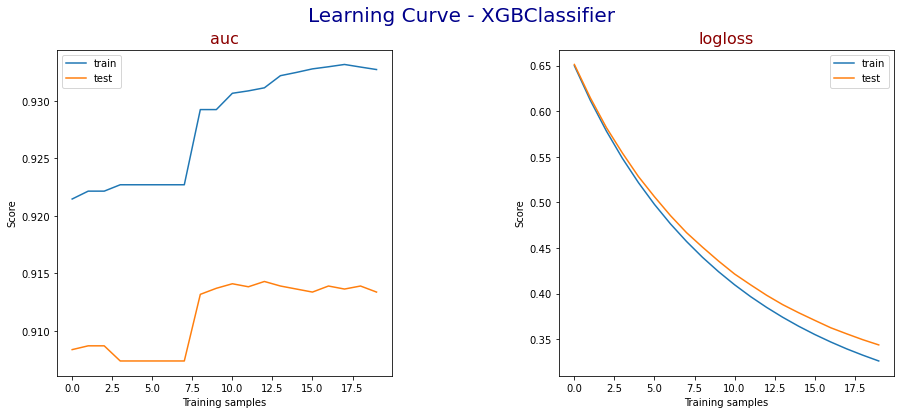

In [149]:
# Setup the model
ml_XGBClassifier = xgb.XGBClassifier()
best_params_XGBClassifier['seed'] = SEED
#best_params_XGBClassifier['n_estimators'] = 20
ml_XGBClassifier = xgb.XGBClassifier(**best_params_XGBClassifier)

##############################################
## Applying model
##############################################
# Fit the classifier to the training set
#metrics = ['auc', 'error']
metrics = ['auc', 'logloss']
ml_XGBClassifier.fit(X_train, y_train, eval_metric=metrics, eval_set=evalset, verbose=0)

# Predict the labels
preds_train = ml_XGBClassifier.predict(X_train)
preds_test  = ml_XGBClassifier.predict(X_test)

# evaluate performance - Compute the accuracy
results_train = accuracy_score(y_train, preds_train)
results_test = accuracy_score(y_test, preds_test)
print("Accuracy on the training set: ", results_train)
print("Accuracy on the test set    : ", results_test)

# Saving results 
ml_result['XGBClassifier'] = {'Model': 'ml_XGBClassifier', 'Train_auc': results_train}
ml_result['XGBClassifier'].update({'Test_auc': results_test})
ml_result['XGBClassifier'].update({'Train_logloss': log_loss(y_train, preds_train)})
ml_result['XGBClassifier'].update({'Test_logloss': log_loss(y_test, preds_test)})


##############################################
## Plotting learning curve
##############################################
# retrieve performance metrics
results = ml_XGBClassifier.evals_result()

# plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, metric in zip(axes, metrics):
    ax.plot(results['validation_0'][metric], label='train')
    ax.plot(results['validation_1'][metric], label='test')
    ax.legend()
    ax.set_title(metric, **title_param)
    ax.set_xlabel('Training samples')
    ax.set_ylabel('Score')
fig.suptitle('Learning Curve - XGBClassifier', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
plt.show()

# 6. MODEL RESULTS

In [103]:
pd.DataFrame.from_dict(ml_result, orient='index').sort_index()

,Model,Train_auc,Test_auc,Train_logloss,Test_logloss
XGBClassifier,ml_XGBClassifier,0.905899,0.871508,3.250148,4.437979


# 7. APPLY THE BEST MODEL

In [146]:
final_result = X_final_test.copy(deep=True)
final_result.index = df_test.index
final_result['Survived'] = ml_XGBClassifier.predict(X_final_test)
#final_result['Survived'].to_numpy()
final_result[['Survived']].to_csv('predict_test_XGBClassifier.csv')